In [58]:
using DynamicalSystems
using Plots
using Flux
using Flux: @epochs
using LinearAlgebra
# Graphs 
using LightGraphs, SimpleWeightedGraphs
using GraphPlot
using CUDA
using Optim
using DataFrames

gr()

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1260


Plots.GRBackend()

### Lorenz System

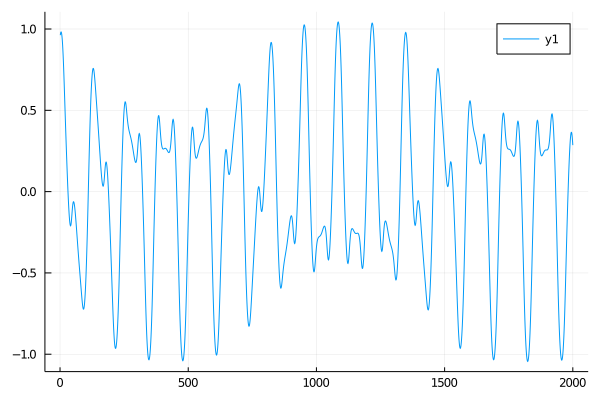

In [51]:
T = 2000
dpend = DynamicalSystemsBase.Systems.double_pendulum(rand(4); G=10.0, L1 = 1.0, L2 = 1.0, M1 = 1.0, M2 = 1.0);
u = trajectory(dpend, 100.0; dt = 0.02)
plot(u[1:T,1])

In [110]:
U = Dataset([u[:, 1] u[:, 3]]);

### Reservoir

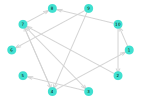

In [111]:
Dᵣ = 10
p = 1.2/Dᵣ
G = erdos_renyi(Dᵣ, p, is_directed=true)
while true
    
    G = erdos_renyi(Dᵣ, p, is_directed=true)
    
    if is_connected(G) == true && maximum(abs.(eigvals(Array(adjacency_matrix(G))))) <1.3 && maximum(abs.(eigvals(Array(adjacency_matrix(G)))))>1.1
        break
    end
    
end
gplot(G, layout=circular_layout, nodelabel=1:Dᵣ)

### Adjacency matrix

In [112]:
Dₛ = 2
A = adjacency_matrix(G);
Wᵢₙ = rand(0:100, Dᵣ, Dₛ)*0.0005;
maximum(abs.(eigvals(Array(A))))

1.2365057033914995

### Equation of motion reservoir + driving

In [113]:
function loop(r, p, t)
    A = p[1]; Wᵢₙ = p[2]
    rₜ₊₁ = []
    for i ∈ 1:Dᵣ
        rₜ₊₁ = append!(rₜ₊₁, tanh((Array(A[i,:])' * r) + (Array(Wᵢₙ[i,:])' * U[t])))
    end
    return SVector{Dᵣ}(rₜ₊₁)
end

loop (generic function with 1 method)

### Discrete dynamical system

In [114]:
p = [A, Wᵢₙ]
Reservoir = DiscreteDynamicalSystem(loop, rand(Dᵣ), p; t0 = 1);

In [115]:
tr = trajectory(Reservoir, T-1);

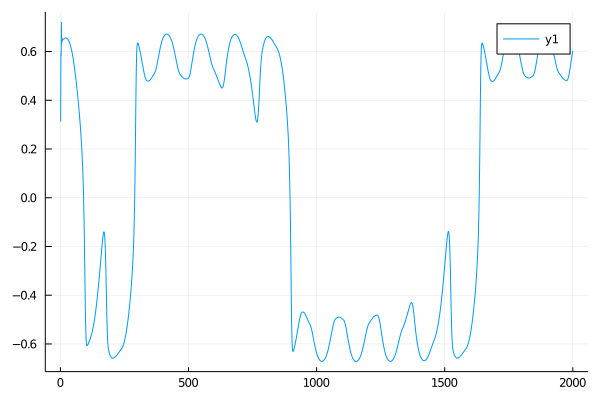

In [120]:
plot(tr[:,2])

### CUDA training

In [9]:
start_train = 10

X_train = CuArray(tr[start_train:end])
Y_train = CuArray(u[start_train:end])


Φ = Chain(Dense(Dᵣ, 3))

loss(x,y) = sum(abs2, Φ(x) .- y)
ps = Flux.params(Φ);

data = zip(X_train, Y_train);
#data = zip(tr[start_train:end], u[start_train:end]);
@time begin

    @epochs 1 Flux.train!(loss, ps, data, ADAM(0.001))

end

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDA C:\Users\valpe\.julia\packages\CUDA\5t6R9\deps\compatibility.jl:176
┌ Info: Epoch 1
└ @ Main C:\Users\valpe\.julia\packages\Flux\Fj3bt\src\optimise\train.jl:121
┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays C:\Users\valpe\.julia\packages\GPUArrays\JqOUg\src\host\indexing.jl:43


 40.548278 seconds (128.43 M allocations: 9.894 GiB, 3.23% gc time)


### Non CUDA training

In [138]:
start_train = 10

X_train = tr[start_train:end]
Y_train = U[start_train:end]


Φ = Chain(Dense(Dᵣ, Dₛ))

loss(x,y) = sum(abs2, Φ(x) .- y)
ps = Flux.params(Φ);


data = zip(X_train, Y_train);
#data = zip(tr[start_train:end], u[start_train:end]);


#@time begin
#    @epochs 100 Flux.train!(loss, ps, data, ADAM(0.001))
#end

N = 1000
losses = []
for i ∈ 1:N
    Flux.train!(loss, ps, data, ADAM(0.003))
    
    l = 0
    for j ∈ 1:100
        l = l + loss(tr[2*j+10], U[2*j+10])
    end
    
    losses = push!(losses, l)
    if i%(50)==0
        println((i/N)*100, "%")
        println("loss: ", l)
    end
end

5.0%
loss: 3.996463275851447
10.0%
loss: 3.684002345693433
15.0%
loss: 3.569121415940436
20.0%
loss: 3.5078859453493405
25.0%
loss: 3.4646789113364567
30.0%
loss: 3.4285403098333074
35.0%
loss: 3.395575375009309
40.0%
loss: 3.3639586890538533
45.0%
loss: 3.3327394901803684
50.0%
loss: 3.3017429344687144
55.00000000000001%
loss: 3.2718125552530033
60.0%
loss: 3.244183146346209
65.0%
loss: 3.2163589478063215
70.0%
loss: 3.1866283359701266
75.0%
loss: 3.1554032987687
80.0%
loss: 3.1604267017160295
85.0%
loss: 3.189673245305583
90.0%
loss: 3.1500383797887754
95.0%
loss: 3.10388381630475
100.0%
loss: 3.067578738392292


### Changing step size

In [126]:
N = 100
losses = []
for i ∈ 1:N
    Flux.train!(loss, ps, data, ADAM(0.01))
    
    l = 0
    for j ∈ 1:100
        l = l + loss(tr[2*j+10], U[2*j+10])
    end
    
    losses = push!(losses, l)
    if i%(5)==0
        println((i/N)*100, "%")
        println("loss: ", l)
    end
end

5.0%
loss: 26.85788868678119
10.0%
loss: 37.660389317084864
15.0%
loss: 29.461537763525705
20.0%
loss: 30.30306910354356
25.0%
loss: 30.686123716753006
30.0%
loss: 31.090325043997044
35.0%
loss: 31.448930135719987
40.0%
loss: 31.77193981863769
45.0%
loss: 32.05954197842111
50.0%
loss: 32.314646083945
55.00000000000001%
loss: 32.54307060215445
60.0%
loss: 32.74651868324884
65.0%
loss: 32.92906620681435
70.0%
loss: 33.09361781432695
75.0%
loss: 33.24388158213127
80.0%
loss: 33.38141625599539
85.0%
loss: 33.50936628110263
90.0%
loss: 33.6284583229989
95.0%
loss: 33.74088195694589
100.0%
loss: 33.84662002755716


### Plot the loss

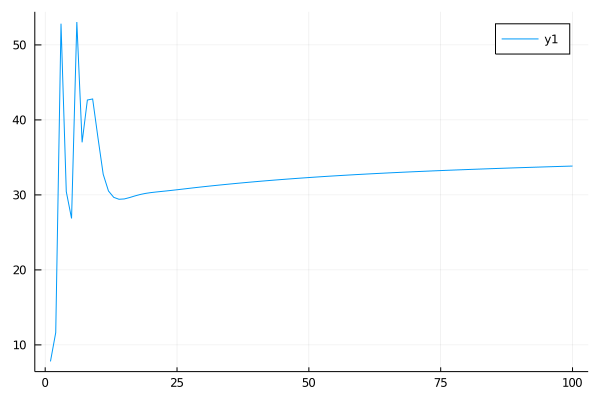

In [127]:
plot(losses)

In [133]:
test = []
for i ∈ 1:T
    test = push!(test, Φ(tr[i,:])[1])
end
loss(tr[200], U[200])

0.10629181119825651

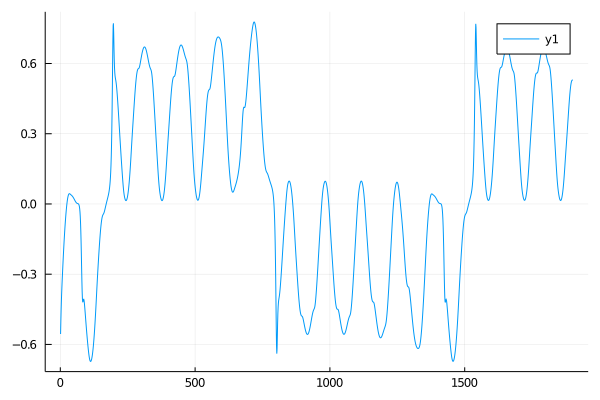

In [134]:
plot(test[100:end])

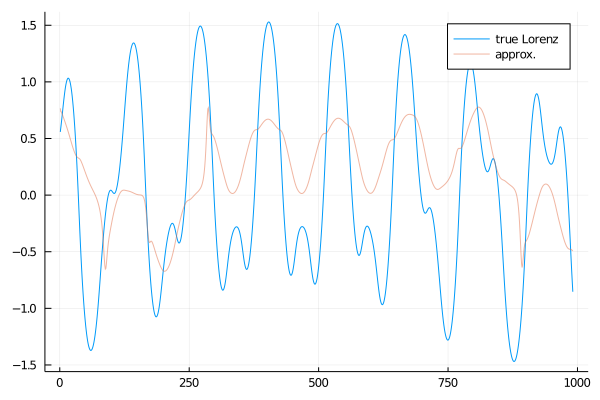

In [137]:
plot(U[10:1000,2], label = "true Lorenz")
plot!(test[10:1000], alpha = 0.5, label = "approx.")

### Prediction

### Lorenz System

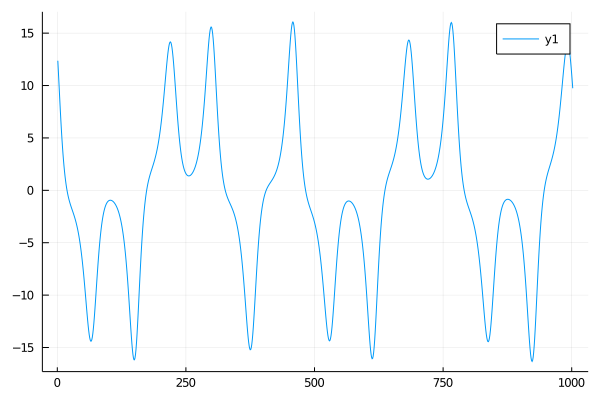

In [96]:
lorenz = DynamicalSystemsBase.Systems.lorenz([10.0, 10.0, 10.0]; σ = 10.0, ρ = 28.0, β = 8/3);
u = trajectory(lorenz, 20.0; dt = 0.01)
plot(u[1000:end,1])

In [97]:
function loop_test(r, p, t)
    A = p[1]; Wᵢₙ = p[2]
    rₜ₊₁ = []
    for i ∈ 1:Dᵣ
        rₜ₊₁ = append!(rₜ₊₁, tanh((Array(A[i,:])' * r) + (Array(Wᵢₙ[i,:])' * Φ(r))))
        #rₜ₊₁ = append!(rₜ₊₁, tanh((Array(A[i,:])' * r) + (Array(Wᵢₙ[i,:])' * u[t])))
    end
    return SVector{Dᵣ}(rₜ₊₁)
end

loop_test (generic function with 1 method)

In [98]:
Reservoir = DiscreteDynamicalSystem(loop_test, rand(Dᵣ), p; t0 = 1);

In [99]:
tr_predict = trajectory(Reservoir, 500-1)

23-dimensional Dataset{Float64} with 500 points
 0.982806  0.548934  0.989266  0.0831477  …  0.8611    0.605197  0.677903
 0.991689  0.916299  0.99943   0.998742      0.998158  0.987309  0.995851
 0.999046  0.900041  0.999957  0.999934      0.99938   0.999     0.993852
 0.998805  0.879392  0.999942  0.999922      0.998991  0.99879   0.990888
 0.998619  0.863794  0.999927  0.99991       0.998624  0.998581  0.988228
 0.998482  0.852298  0.999914  0.999901   …  0.998305  0.998413  0.986024
 0.998378  0.843762  0.999903  0.999894      0.998038  0.998282  0.984251
 0.9983    0.837368  0.999895  0.999889      0.997821  0.99818   0.982844
 0.998241  0.832543  0.999888  0.999884      0.997647  0.9981    0.981738
 0.998195  0.828879  0.999883  0.999881      0.997508  0.998039  0.980871
 0.998161  0.826084  0.999879  0.999879   …  0.997399  0.997991  0.980195
 0.998134  0.823945  0.999875  0.999877      0.997313  0.997954  0.979668
 0.998114  0.822303  0.999873  0.999875      0.997245  0.997925 

In [100]:
test_predict = []
for i ∈ 1:500
    test_predict = push!(test_predict, Φ(tr_predict[i,:])[3])
end

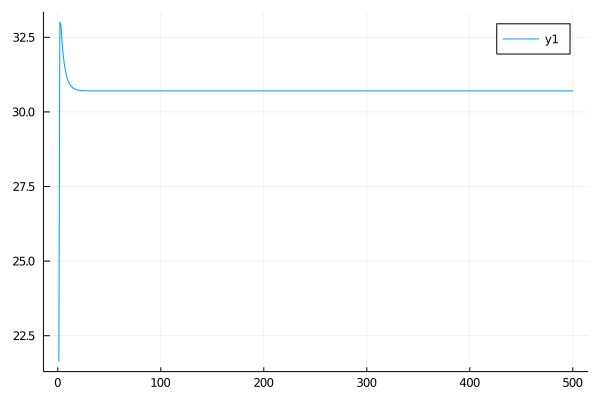

In [101]:
plot(test_predict[1:end])
#plot!(u[T-1:T+100, 3])

# Expected Spectral Radius of Connected Erdos-Renyi

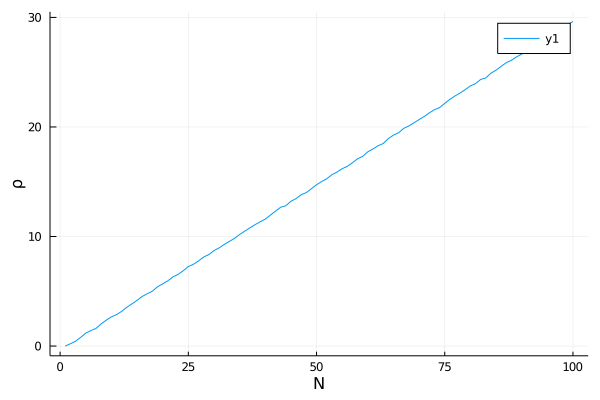

In [10]:
R = []
N = 100
p = 0.3

for i in 1:100
    ρ = 0
    
    G = erdos_renyi(i, p, is_directed=true)
    for j in 1:N
        while true
            G = erdos_renyi(i, p, is_directed=true)
            if is_connected(G) == true
                break
            end
        end
        ρ = ρ + maximum(abs.(eigvals(Array(adjacency_matrix(G)))))
    end
    
    R = append!(R, ρ/N)
end

plot(R, ylabel = "ρ", xlabel = "N")